# Introduction
This project is aimed to use a statistical model to predict the wind stress anomalies by sea surface temperature anomalies (SSTA). The relationship can be represented as $\boldsymbol{\tau_s} = \boldsymbol{C} \boldsymbol{T}$, where $\boldsymbol{\tau_s}$ and $\boldsymbol{T}$ are state vectors of wind stress anomolies and SSTA, respectively, and $\boldsymbol{C}$ is a constant coefficient (a matrix). Our goal is to derive $\boldsymbol{C}$ using Singular Value Decomposition (SVD) analysis on a training dataset, and apply the relationship on a testing dataset.

This project is going to:

1. Formulate a statistical atmosphere model for predicting surface wind stress anomalies for given SST anomalies;
2. Validate the simulated surface wind stress anomalies against observations;
3. Perform sensitivity tests to see how the results depend on the number of SVDs used to compute the anomalies;
4. Discuss whether the results make physical sense and why;

# Dataset and Method
Surface temperature ($T_s$), zonal wind stress ($u$), meridional wind stress ($v$), and a land mask dataset are given. $T_s, u, v$ are three-dimensional, with two space dimensions and one time dimension. Datasets are divided into two parts: data in 1948-1999 are used as training dataset, and data in 2000-2017 are used as testing dataset.

We follow the below steps to perform the SVD analysis:

1. Normalize all the anomaly fields by dividing each of variables by its own standard deviation;
2. Form a state vector for SSTA ($\boldsymbol{T}$), and another one for zonal and meridional wind stress anomaly ($\boldsymbol{\tau_s}$). Note that $\boldsymbol{\tau_s}$ contains both wind stress component and has larger dimension than $\boldsymbol{T}$;
3. Form a normalized covariance matrix, $\boldsymbol{A=\tau _s T'}$, whose dimension should be $M\times N$, where $M$ is the length for $\boldsymbol{\tau_s}$ and $N$ is length for $\boldsymbol{T}$;
4. Apply SVD on $\boldsymbol{A}$ by calling Matlab’s SVD function, which results in $\boldsymbol{A=USV'}$, $S$ is a diagonal matrix with diagonal elements representing singular values - explained squared covariance in each SVD, $\boldsymbol{U}$ contains all wind stress singular vectors and $V$ contains all SST singular vectors, which are self-orthogonal, i.e., $\boldsymbol{VV'=I}$ and $\boldsymbol{UU'=I}$. 

# Results
## SVD analysis
Although the SVD MATLAB scripts are provided, I rewrite them in Python in order to better understand the SVD method. The Python script is below:

In [1]:
import numpy.linalg as la
import xarray as xr
import numpy as np

# read in the data
dir = "./NECP_monthly_mean_data/"
taux_ds = xr.open_dataset(dir + "uflx.sfc.mon.mean.tropics.nc", use_cftime=True)
tauy_ds = xr.open_dataset(dir + "vflx.sfc.mon.mean.tropics.nc", use_cftime=True)
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
taux, tauy, sst, grid = taux_ds.uflx, tauy_ds.vflx, sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
taux = taux.reindex(lat=taux.lat[::-1])
tauy = tauy.reindex(lat=tauy.lat[::-1])
sst = sst.reindex(lat=sst.lat[::-1])
grid = grid.reindex(lat=grid.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 100E-60W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 100, 300
taux = taux.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
tauy = tauy.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
sst = sst.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid.sel(lon=slice(lon_min, lon_max))
lat, lon = taux.lat.values, taux.lon.values
# get the data as numpy arrays
taux, tauy, sst, grid = taux.values, tauy.values, sst.values, grid.values
grid = grid[0,:,:]
# get dimensions
nt, ny, nx = taux.shape
# reshape the time dimension to nmonths x nyears
taux = taux.reshape(nt//12, 12, ny, nx)
tauy = tauy.reshape(nt//12, 12, ny, nx)
sst = sst.reshape(nt//12, 12, ny, nx)
# get seasonal means
taux_mean = taux.mean(axis=0, keepdims=True)
tauy_mean = tauy.mean(axis=0, keepdims=True)
sst_mean = sst.mean(axis=0, keepdims=True)
# remove seasonal cycle
taux_anom = taux - taux_mean
tauy_anom = tauy - tauy_mean
sst_anom = sst - sst_mean
# reshape time to 1D
taux_anom = taux_anom.reshape(nt, ny, nx)
tauy_anom = tauy_anom.reshape(nt, ny, nx)
sst_anom = sst_anom.reshape(nt, ny, nx)
# normalize the data by the standard deviation
taux_anom /= taux_anom.std()
tauy_anom /= tauy_anom.std()
sst_anom /= sst_anom.std()
# mask out the land
taux_anom[:, grid == -1] = 0
tauy_anom[:, grid == -1] = 0
sst_anom[:, grid == -1] = 0
# concatenate taux and tauy
tau = np.concatenate((taux_anom, tauy_anom), axis=1)
# reshape vars to space x time
tau = tau.reshape(nt, 2*ny*nx).T 
sst = sst_anom.reshape(nt, ny*nx).T
# form matrix A
A = 1/nt * tau @ sst.T
# apply SVD on A
U, S, V = la.svd(A, full_matrices=True)

In [5]:
print(U.shape, S.shape, V.shape)
n_modes = 10
# get the explained variance
var = (S**2) / (S**2).sum()
# get the first n_modes modes
tau_modes = U[:, :n_modes]
sst_modes = V[:n_modes, :]
var_modes = var[:n_modes]
# get the spatial patterns
tau_modes = tau_modes.reshape(2*ny, nx, n_modes)
taux_modes = tau_modes[:ny, :, :]
tauy_modes = tau_modes[ny:, :, :]
sst_modes = sst_modes.reshape(ny, nx, n_modes)

(6848, 6848) (3424,) (3424, 3424)


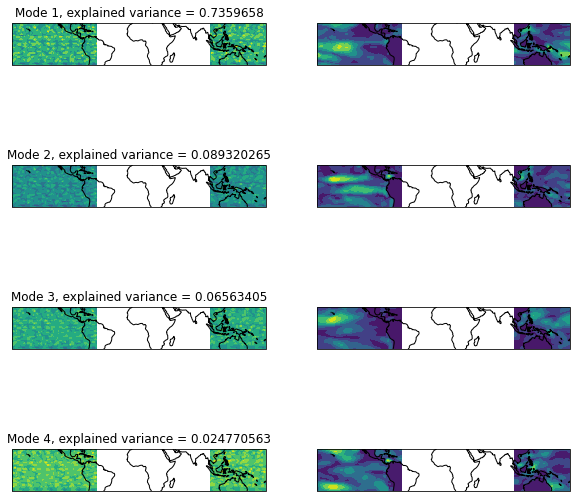

In [7]:
# plot the spatial patterns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plot_modes = 4

fig, axes = plt.subplots(plot_modes, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(plot_modes):
    ax = axes[i, 0]
    # only plot lat_min to lat_max, lon_min to lon_max
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_title("Mode " + str(i+1) + ", explained variance = " + str(var_modes[i]))
    ax.contourf(lon, lat, sst_modes[:,:,i], transform=ccrs.PlateCarree())
    ax.coastlines()
    ax = axes[i, 1]
    # only plot lat_min to lat_max, lon_min to lon_max
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    tau_mag = np.sqrt(taux_modes[:,:,i]**2 + tauy_modes[:,:,i]**2)
    ax.contourf(lon, lat, tau_mag, transform=ccrs.PlateCarree())
    ax.coastlines()
plt.show()